# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.as_numpy_iterator())[:2])
print(list(val_dataset.as_numpy_iterator())[:2])
print(list(test_dataset.as_numpy_iterator())[:2])

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

# Data Visualizing

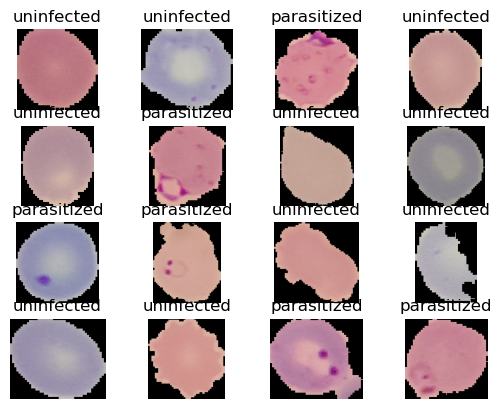

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

## tf.image augment

In [11]:
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image, label

In [12]:
test_dataset = test_dataset.map(resize_rescale)

In [13]:
BATCH_SIZE = 32
train_dataset = (train_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(augment)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
               .map(augment)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

# Model Subclassing

In [14]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, droupout_rate, regularizer_rate):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)

        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)
        x = self.pool_1(x)


        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

In [15]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), droupout_rate = 0.3, regularizer_rate = 0.01)

In [16]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation,droupout_rate, regularizer_rate):
        super(LenetModel, self).__init__()

        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides,
                                    padding = padding,
                                    activation_function = activation_function,
                                    pool_size = pool_size,
                                    droupout_rate = droupout_rate,
                                    regularizer_rate = regularizer_rate)
        self.flatten = Flatten()

        self.dense_1 = Dense(units = 100, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.dense_2 = Dense(units = 10, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)

    def call(self, x, training):
        x = self.featureExtractor(x)
        x = self.flatten(x)
        x = self.batch_1(x)
        x = self.droupout1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

In [17]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2),
                         output_activation = "sigmoid", droupout_rate = 0.3, regularizer_rate=0.01)
lenet_model(Input(shape= (IM_SIZE, IM_SIZE,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  0 (unused)
                                                                 
 batch_normalization_4 (Batc  multiple                 760384    
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  

# Optimizers

In [18]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [19]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics)

# Callbacks

In [20]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

    def no_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

## CSVLogger

In [21]:
csv_callback = CSVLogger( 'logs.csv', separator = ',', append = False)

## EarlyStopping

In [22]:
es_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## LearningRateScheduler

In [23]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
callbacks_scheduler = LearningRateScheduler(scheduler, verbose=1)

# ModelCheckpointing

In [25]:
checkpoints_callbacks = ModelCheckpoint(
    'checkpoints/', monitor = 'val_loss', verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

# ReduceLROnPlateau

In [26]:
plateau_callbacks = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.001)

# Train

In [27]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 50, verbose=1, callbacks = [csv_callback, plateau_callbacks])

Epoch 1/50
689/689 [==============================] - 19s 24ms/step - loss: 15.9189 - tp: 6324.0000 - fp: 4773.0000 - fn: 4699.0000 - tn: 6250.0000 - accuracy: 0.5704 - precision: 0.5699 - recall: 0.5737 - auc: 0.6001 - val_loss: 17.0354 - val_tp: 1393.0000 - val_fp: 1362.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_accuracy: 0.5056 - val_precision: 0.5056 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 0.1000
Epoch 2/50
689/689 [==============================] - 16s 23ms/step - loss: 10.9952 - tp: 6350.0000 - fp: 4804.0000 - fn: 4675.0000 - tn: 6217.0000 - accuracy: 0.5700 - precision: 0.5693 - recall: 0.5760 - auc: 0.6007 - val_loss: 5.7921 - val_tp: 1394.0000 - val_fp: 1361.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000 - val_auc: 0.5716 - lr: 0.1000
Epoch 3/50
689/689 [==============================] - 16s 23ms/step - loss: 7.5634 - tp: 6572.0000 - fp: 4923.0000 - fn: 4451.0000 - tn: 6100.0000 - accuracy: 0.57

Epoch 21/50
689/689 [==============================] - 16s 23ms/step - loss: 37.4467 - tp: 6759.0000 - fp: 4206.0000 - fn: 4264.0000 - tn: 6817.0000 - accuracy: 0.6158 - precision: 0.6164 - recall: 0.6132 - auc: 0.6543 - val_loss: 1.1521 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 1396.0000 - val_tn: 1359.0000 - val_accuracy: 0.4933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5542 - lr: 0.1000
Epoch 22/50
689/689 [==============================] - 16s 23ms/step - loss: 9.0861 - tp: 6928.0000 - fp: 4750.0000 - fn: 4095.0000 - tn: 6273.0000 - accuracy: 0.5988 - precision: 0.5933 - recall: 0.6285 - auc: 0.6380 - val_loss: 3.0803 - val_tp: 1389.0000 - val_fp: 1366.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_accuracy: 0.5042 - val_precision: 0.5042 - val_recall: 1.0000 - val_auc: 0.6600 - lr: 0.1000
Epoch 23/50
689/689 [==============================] - 16s 23ms/step - loss: 10.1992 - tp: 6749.0000 - fp: 4547.0000 - fn: 4274.0000 - tn: 6476.0000 - accu

689/689 [==============================] - 16s 23ms/step - loss: 0.7215 - tp: 7618.0000 - fp: 3832.0000 - fn: 3404.0000 - tn: 7192.0000 - accuracy: 0.6718 - precision: 0.6653 - recall: 0.6912 - auc: 0.7283 - val_loss: 0.7734 - val_tp: 88.0000 - val_fp: 14.0000 - val_fn: 1304.0000 - val_tn: 1349.0000 - val_accuracy: 0.5216 - val_precision: 0.8627 - val_recall: 0.0632 - val_auc: 0.7178 - lr: 0.0040
Epoch 40/50
689/689 [==============================] - 16s 23ms/step - loss: 0.7654 - tp: 7631.0000 - fp: 3821.0000 - fn: 3390.0000 - tn: 7204.0000 - accuracy: 0.6729 - precision: 0.6663 - recall: 0.6924 - auc: 0.7271 - val_loss: 0.9238 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_fn: 1391.0000 - val_tn: 1358.0000 - val_accuracy: 0.4951 - val_precision: 1.0000 - val_recall: 0.0043 - val_auc: 0.7048 - lr: 0.0040
Epoch 41/50
689/689 [==============================] - 16s 23ms/step - loss: 0.7931 - tp: 7596.0000 - fp: 3853.0000 - fn: 3428.0000 - tn: 7169.0000 - accuracy: 0.6697 - precision: 0.6635

# Loss

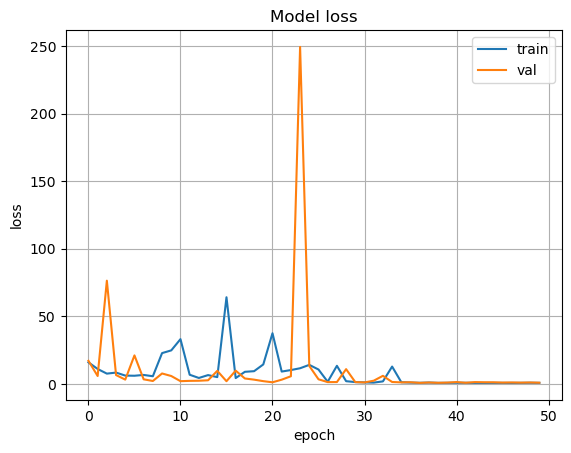

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

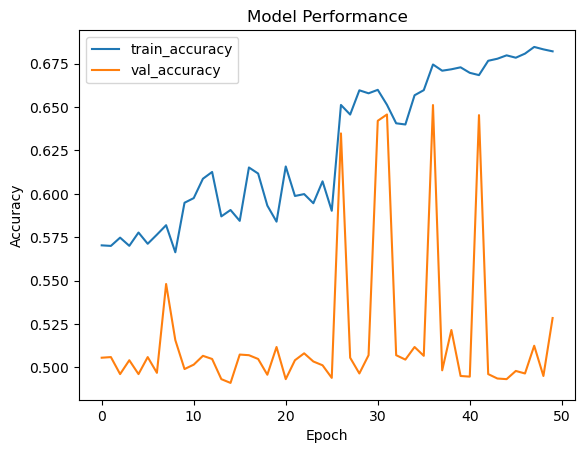

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [30]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [31]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
evals = lenet_model.evaluate(test_dataset, return_dict = True)
evals

2757/2757 [==============================] - 8s 3ms/step - loss: 0.8340 - tp: 124.0000 - fp: 22.0000 - fn: 1241.0000 - tn: 1370.0000 - accuracy: 0.5419 - precision: 0.8493 - recall: 0.0908 - auc: 0.7264


{'loss': 0.8340253829956055,
 'tp': 124.0,
 'fp': 22.0,
 'fn': 1241.0,
 'tn': 1370.0,
 'accuracy': 0.5418933629989624,
 'precision': 0.8493150472640991,
 'recall': 0.09084249287843704,
 'auc': 0.7264131307601929}

# Predict

In [33]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 1s 571ms/step


0.2877426

In [34]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [35]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 1s 525ms/step


'P'

1/1 [==============================] - 0s 10ms/step


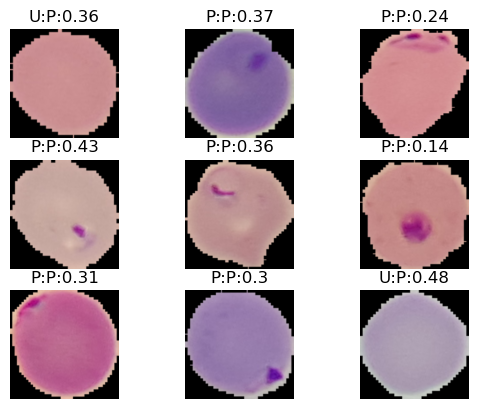

In [36]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    res = lenet_model.predict(image)[0][0]
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
    plt.axis('off')

# Visualising Confusion Matrix

In [37]:
inps = []
labels = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inps.append(x)

In [38]:
labels[:5]

[array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64)]

In [39]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 1 0]


In [40]:
predicted = lenet_model.predict(np.array(inps)[:,0,...])
predicted.shape

87/87 [==============================] - 0s 5ms/step


(2757, 1)

In [41]:
predicted[:, 0]

array([0.40389603, 0.2702382 , 0.22054325, ..., 0.48121274, 0.48947164,
       0.36095068], dtype=float32)

In [42]:
predicted = predicted.squeeze()
predicted.shape

(2757,)

In [43]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[1370   22]
 [1243  122]]


In [44]:
print(cm)

[[1370   22]
 [1243  122]]


Text(0.5, 58.7222222222222, 'Predicted')

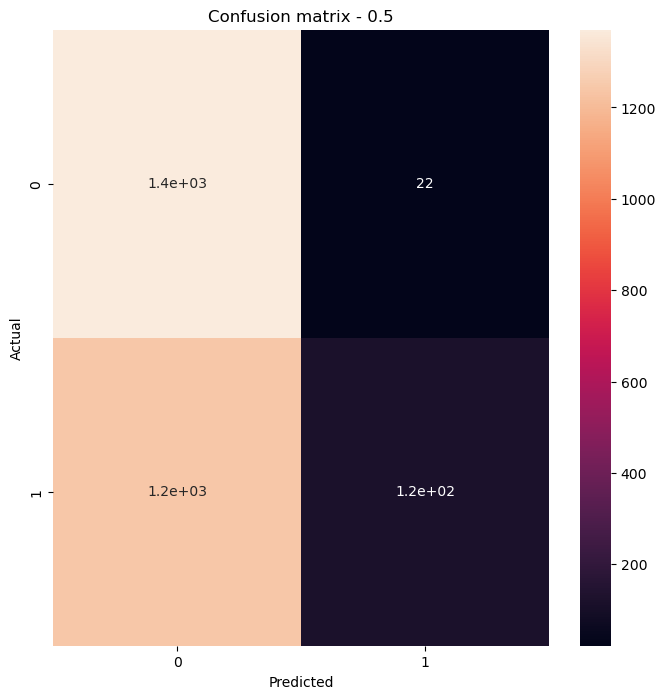

In [45]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

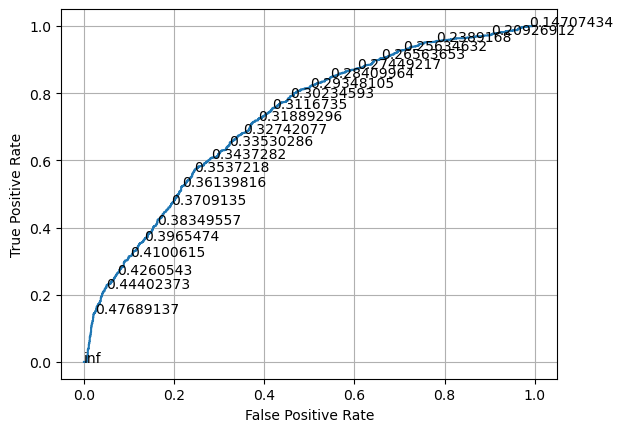

In [46]:
fp, tp ,threshoulds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [47]:
f1 = f1_score(y_true= labels, y_pred= np.round(predicted))
f1

0.16169648774022533